In [5]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.ndimage import map_coordinates
import fabio
import matplotlib.ticker as mticker

warnings.filterwarnings("ignore", 'invalid value')

# inverse mapping
# set parameters
# beam center of detector image, X direction, in pixel; if fit2d was used, [bcx in fit2d]-1
bcx = 1149.8796307197742
# beam center of detector image, Y direction; if fit2d was used, PixelsY (3072 for MAR225)-[bcy in fit2d]
bcy = 3040.791864896859
pixelsize = 0.0732421875  # in mm, 225.0/3072.0 for MAR225, 0.172 for Pilatus, 0.075 for Eiger
distance = 325.8328043862533  # sample-dector distance in mm
wavelength = 1.2398  # in angstrom
background = 'OTS-100s.tif.gz'
sampleName = 'a1-rt-35s.tif.gz'
subratio = 0.35 # factor of background subtraction
colorrange = 2000  # colormap range
incidence = 0.2 * np.pi / 180.0  # in rad

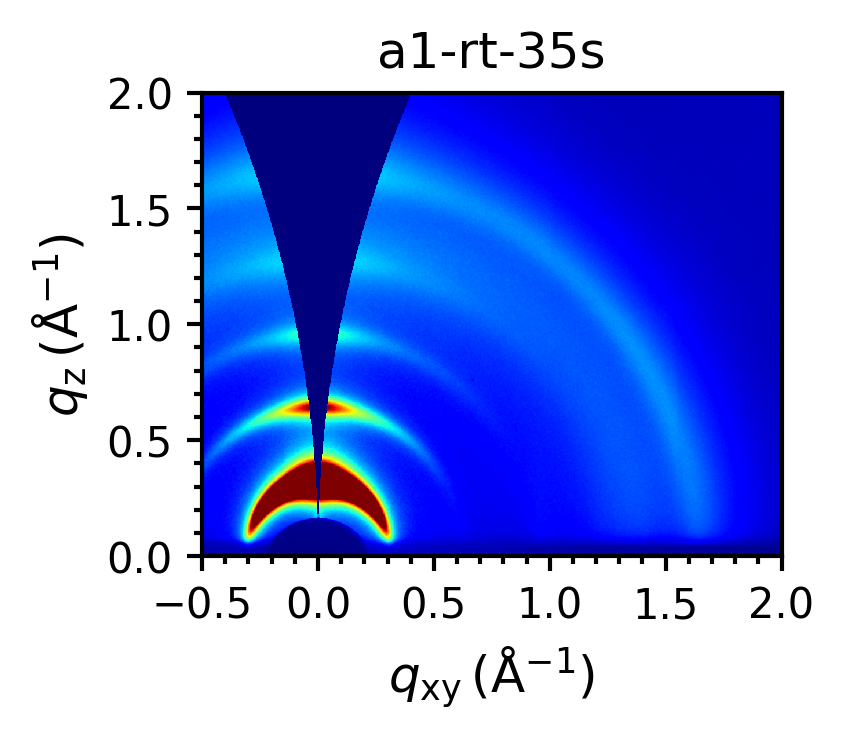

In [6]:
# resolution of the qz-qxy map (0.0025 median, 0.0015 good, 0.005 poor )
qresolution = 0.0025
qxymin = -0.5  # range of q map, in angstrom^-1
qxymax = 2.0
qzmin = 0.0
qzmax = 2.0
denoise = True
colormap = 'jet'  # 'jet', 'viridis', 'inferno', 'plasma', 'magma'
intensity_max = 2000
# background subtraction
im = fabio.open(sampleName).data
bkg = fabio.open(background).data
imarray = im - bkg * subratio  # subtract the background
Npixelsy, Npixelsx = imarray.shape  # dector Y-axis X-axis
qzpoints = int((qzmax - qzmin) / qresolution) + 1
qxypoints = int((qxymax - qxymin) / qresolution) + 1
qxy = np.linspace(qxymin, qxymax, qxypoints)
qz = np.linspace(qzmax, qzmin, qzpoints)
qxy, qz = np.meshgrid(qxy, qz)
qxy_square = qxy**2
q_square = qxy_square + np.multiply(qz, qz)
# constant
distancep = distance / pixelsize
cosai = np.cos(incidence)
sinai = np.sin(incidence)
coeff = 2 * np.pi / wavelength
tanai = np.tan(incidence)

# rotate matrix
R_rot = np.array([[cosai, 0, -sinai], [0, 1, 0], [sinai, 0, cosai]])
# s(sample frame)
qx = qz * tanai - q_square / 2 / coeff / cosai
kxs = qx + coeff * cosai
kys = np.sqrt(qxy_square - np.multiply(qx, qx)) * np.sign(qxy)
kzs = qz - coeff * sinai
# l(lab frame)
rotated = np.matmul(np.stack((kxs, kys, kzs), axis=-1), R_rot.T)
syl = rotated[:, :, 1] / coeff
szl = rotated[:, :, 2] / coeff

delta = np.arcsin(szl)
cosdelta = np.cos(delta)
gamma = np.arcsin(syl / cosdelta)
tandelta = np.tan(delta)
tangamma = np.tan(gamma)
cosgamma = np.cos(gamma)

px = distancep * tangamma + bcx
py = bcy - tandelta * distancep / cosgamma

intensity = map_coordinates(imarray, np.asarray([py, px]), order=1)
if denoise:
    intensity = signal.medfilt2d(intensity, 3)
plt.figure(figsize=(3, 2.5), dpi=300)
params = {
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'axes.linewidth': 1,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1
}
plt.rcParams.update(params)
plt.title(sampleName.split('.')[0])
plt.imshow(intensity, cmap=colormap,extent=(qxymin, qxymax, qzmin, qzmax), interpolation="nearest",vmin=0,
           vmax=intensity_max)
plt.clim(0, colorrange)
ax = plt.gca()
plt.xlabel(r'$q_\mathrm{xy}\/(\mathrm{\AA}^{-1})$',
           fontsize=12,
           family="Arial")
plt.ylabel(r'$q_\mathrm{z}\/(\mathrm{\AA}^{-1})$', fontsize=12, family="Arial")
ax.minorticks_on()
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.1))
plt.tight_layout()
# plt.savefig('q_'+sampleName.split('.')[0]+'.pdf')
# plt.colorbar()
plt.show()
